In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from sklearn.metrics import precision_recall_fscore_support

In [2]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
dataset_path = r'D:\AI\Project\mammals'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

class_names=dataset.classes

print(dataset.class_to_idx)

{'african_elephant': 0, 'alpaca': 1, 'american_bison': 2, 'anteater': 3, 'arctic_fox': 4, 'armadillo': 5, 'baboon': 6, 'badger': 7, 'blue_whale': 8, 'brown_bear': 9, 'camel': 10, 'dolphin': 11, 'giraffe': 12, 'groundhog': 13, 'highland_cattle': 14, 'horse': 15, 'jackal': 16, 'kangaroo': 17, 'koala': 18, 'manatee': 19, 'mongoose': 20, 'mountain_goat': 21, 'opossum': 22, 'orangutan': 23, 'otter': 24, 'polar_bear': 25, 'porcupine': 26, 'red_panda': 27, 'rhinoceros': 28, 'sea_lion': 29, 'seal': 30, 'snow_leopard': 31, 'squirrel': 32, 'sugar_glider': 33, 'tapir': 34, 'vampire_bat': 35, 'vicuna': 36, 'walrus': 37, 'warthog': 38, 'water_buffalo': 39, 'weasel': 40, 'wildebeest': 41, 'wombat': 42, 'yak': 43, 'zebra': 44}


In [4]:
train_size = int(0.7 * len(dataset))  # 70% training
val_size = int(0.15 * len(dataset))   # 15% validation
test_size = len(dataset) - train_size - val_size  # 15% testing

In [5]:
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [6]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
model = models.resnet50(weights=False)

C:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
model.fc = nn.Sequential(
    nn.Dropout(0.5),  
    nn.Linear(model.fc.in_features, 45)  
)

In [10]:
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
num_epochs = 15 
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() 

        # forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch [1/15], Loss: 3.7302, Accuracy: 6.37%
Epoch [2/15], Loss: 3.4653, Accuracy: 10.49%
Epoch [3/15], Loss: 3.3242, Accuracy: 13.25%
Epoch [4/15], Loss: 3.2705, Accuracy: 15.03%
Epoch [5/15], Loss: 3.2304, Accuracy: 15.41%
Epoch [6/15], Loss: 3.2013, Accuracy: 15.80%
Epoch [7/15], Loss: 3.0589, Accuracy: 18.58%
Epoch [8/15], Loss: 3.0098, Accuracy: 19.61%
Epoch [9/15], Loss: 2.9383, Accuracy: 21.82%
Epoch [10/15], Loss: 2.8803, Accuracy: 23.66%
Epoch [11/15], Loss: 2.8096, Accuracy: 24.33%
Epoch [12/15], Loss: 2.7966, Accuracy: 24.84%
Epoch [13/15], Loss: 2.7574, Accuracy: 26.03%
Epoch [14/15], Loss: 2.7124, Accuracy: 27.01%
Epoch [15/15], Loss: 2.6826, Accuracy: 28.55%


In [ ]:
torch.save(model, "ResNet50_model3.pth")


In [15]:
model.eval() 
val_loss = 0.0
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()


In [16]:
val_loss /= len(val_loader)
val_accuracy = 100 * val_correct / val_total
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 2.5883, Validation Accuracy: 30.16%


In [17]:
model.eval() 
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

In [18]:
test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 2.6018, Test Accuracy: 30.38%


In [19]:
def show_random_test_prediction(model, test_data, class_names):
    model.eval()  

    random_idx = random.randint(0, len(test_data) - 1)
    image, true_label = test_data[random_idx]

    image_tensor = image.unsqueeze(0).to(device)  

    with torch.no_grad(): 
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)

    image_np = image.cpu().numpy().transpose((1, 2, 0)) 
    image_np = np.clip(image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1) 

    plt.imshow(image_np)
    plt.title(f"Predicted: {class_names[predicted_label.item()]}, Actual: {class_names[true_label]}")
    plt.axis("off")
    plt.show()

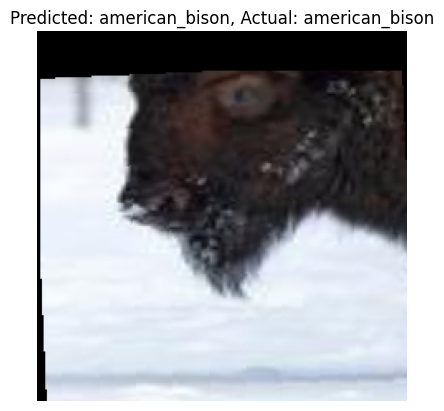

In [54]:
show_random_test_prediction(model, test_data, class_names)

In [21]:
val_loss = 0.0
val_correct = 0
val_total = 0
all_val_labels = []
all_val_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        all_val_labels.extend(labels.cpu().numpy())
        all_val_preds.extend(predicted.cpu().numpy())

val_loss /= len(val_loader)
val_accuracy = 100 * val_correct / val_total
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

precision, recall, f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='weighted')

print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_preds, average='weighted')

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Validation Loss: 2.6346, Validation Accuracy: 29.24%
Validation Precision: 0.2963
Validation Recall: 0.2924
Validation F1-Score: 0.2758
Test Loss: 2.5558, Test Accuracy: 30.67%
Test Precision: 0.3145
Test Recall: 0.3067
Test F1-Score: 0.2906


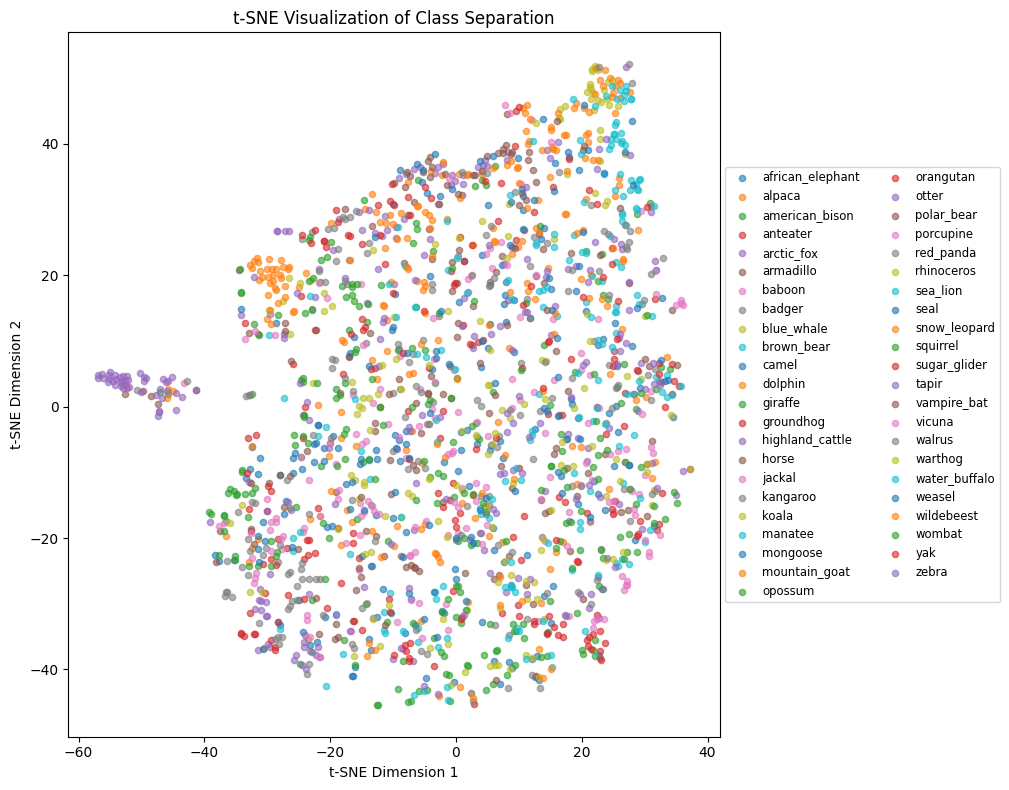

In [25]:
from sklearn.manifold import TSNE
import cv2

def extract_features_for_tsne(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, lbls in data_loader:
            inputs = inputs.to(device)
            lbls = lbls.to(device)

            features_batch = model(inputs)
            features.append(features_batch.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

def visualize_tsne(features, labels, class_names):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)

    plt.figure(figsize=(12, 8))
    
    for i, class_name in enumerate(class_names):
        idx = labels == i
        plt.scatter(tsne_features[idx, 0], tsne_features[idx, 1], label=class_name, alpha=0.6, s=20)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=2)

    plt.title("t-SNE Visualization of Class Separation")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

features, labels = extract_features_for_tsne(model, val_loader, device)
visualize_tsne(features, labels, class_names)